In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, pearsonr
from sklearn.cluster import KMeans

In [2]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [3]:
# Génération des données
def generate_data(n=100, rho=0.9):
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    return np.random.multivariate_normal(mean, cov, size=n)
data = generate_data()

In [4]:
data = pd.DataFrame(data)
data.head()

,0,1
0,0.559617,0.563725
1,1.490247,1.316420
2,0.490980,0.285405
3,-0.500259,0.274140
4,0.214651,1.038815


# Analyse univariée

In [5]:
data.describe()

,0,1
count,100.000000,100.000000
mean,-0.023675,-0.019827
std,0.984400,0.976765
min,-2.258616,-2.104024
25%,-0.665633,-0.655757
50%,-0.127915,0.058506
75%,0.631285,0.619479
max,2.724558,2.860033


(array([ 8.,  5., 13., 23., 14., 17., 14.,  5.,  0.,  1.]),
 array([-2.10402371, -1.60761802, -1.11121234, -0.61480665, -0.11840096,
         0.37800473,  0.87441041,  1.3708161 ,  1.86722179,  2.36362748,
         2.86003316]),
 <BarContainer object of 10 artists>)

<Figure size 2000x1600 with 0 Axes>

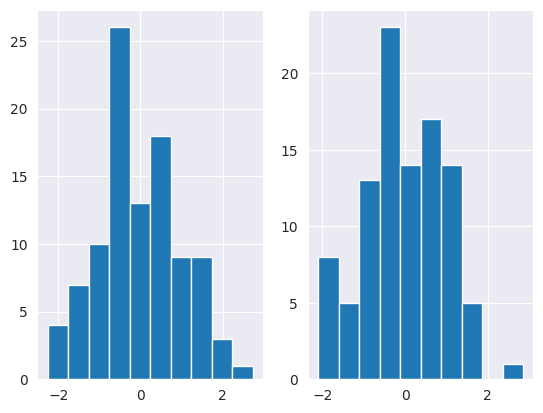

In [6]:
plt.figure(figsize=(20, 16))
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].hist(data[0])
ax[1].hist(data[1])

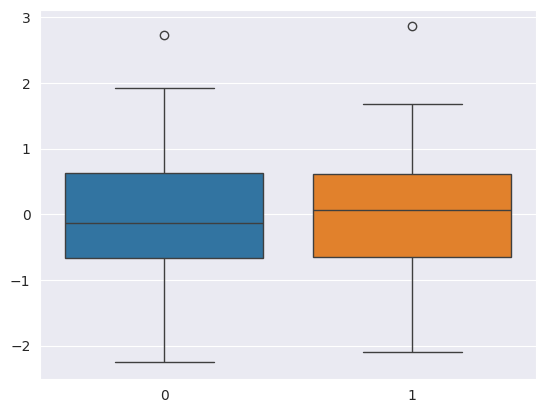

In [7]:
sns.boxplot(data)
plt.show()

In [8]:
# Test de normalité

stat, p_value = shapiro(data[0])
print(f"Statistic : {stat} \t p_value : {p_value}")

stat, p_value = shapiro(data[1])
print(f"Statistic : {stat}, \t p_value : {p_value}")

Statistic : 0.9911947169362479 	 p_value : 0.7603042132142788
Statistic : 0.9864885427075585, 	 p_value : 0.4041596430268297


Nos deux variables suivent une loi normale

# Analyse bivariée

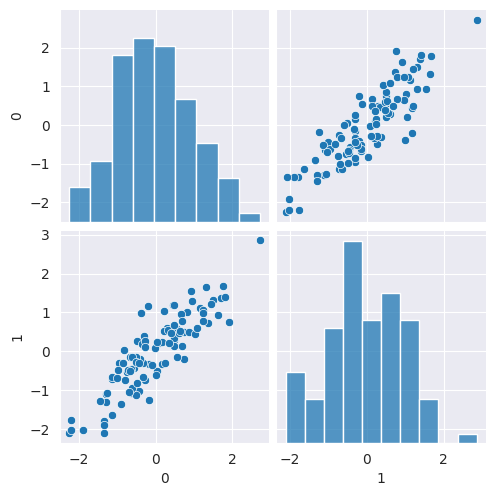

In [9]:
sns.pairplot(data=data)
plt.show()

Nos deux variables semblent avoir une corrélation linéaire positive très forte

# Test Statistique

In [10]:
# Test de Pearson

stat, p_value = pearsonr(data[0], data[1])
print(f"Statistic : {stat} \t p_value : {p_value}")

Statistic : 0.8791385463007798 	 p_value : 2.606026260359916e-33


Nos deux variables sont bels et bien corrélées

# Analyse en Composantes Principales ACP

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection

In [12]:
index = data.index
X = data.values
columns = data.columns

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
variance_exp = pca.explained_variance_ratio_
cumul_var = np.cumsum(variance_exp)

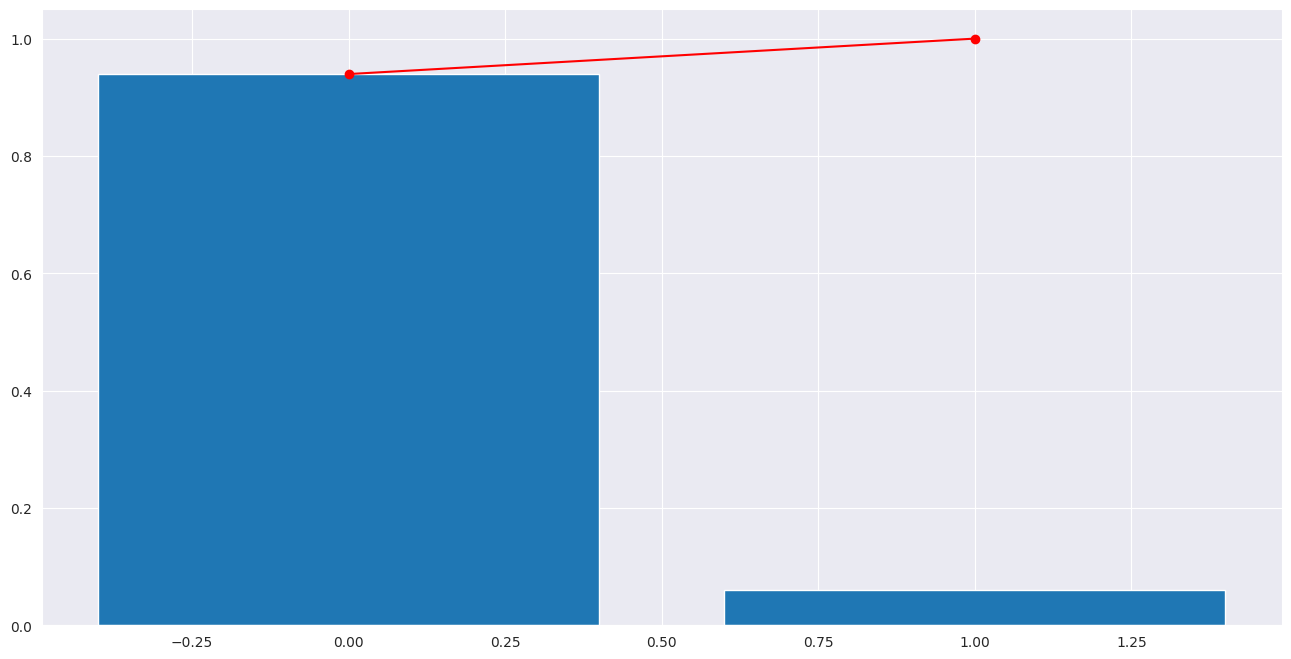

In [15]:
plt.figure(figsize=(16, 8))
plt.bar(height=variance_exp, x=list(range(n_components)))
plt.plot(cumul_var, marker="o", color="red")

Comme on pouvait s'y attendre le premier plan factoriel explique 100% de la variance

In [16]:
pcs = pca.components_
pcs_df = pd.DataFrame(pcs, columns=columns, index=[f"F{i+1}" for i in range(n_components)])
pcs_df.transpose()

,F1,F2
0,0.707107,-0.707107
1,0.707107,0.707107


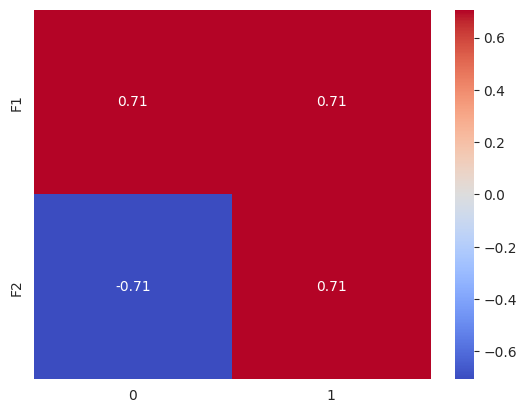

In [17]:
sns.heatmap(pcs_df, annot=True, cmap="coolwarm")
plt.show()

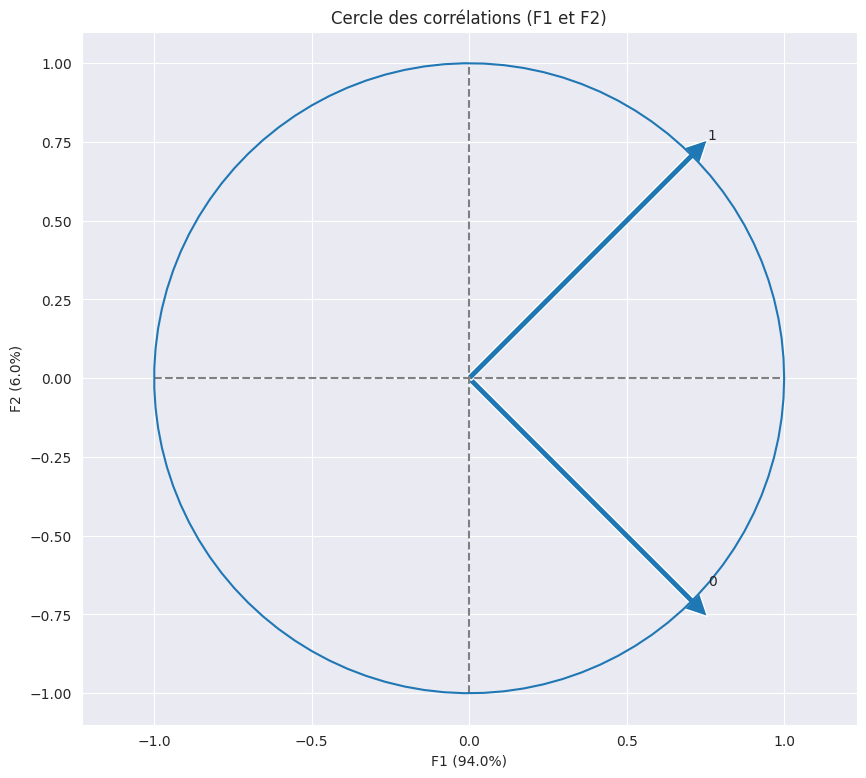

In [18]:
x_y = (0, 1)
correlation_graph(pca, x_y, columns)

Projection sur le premier plan factoriel

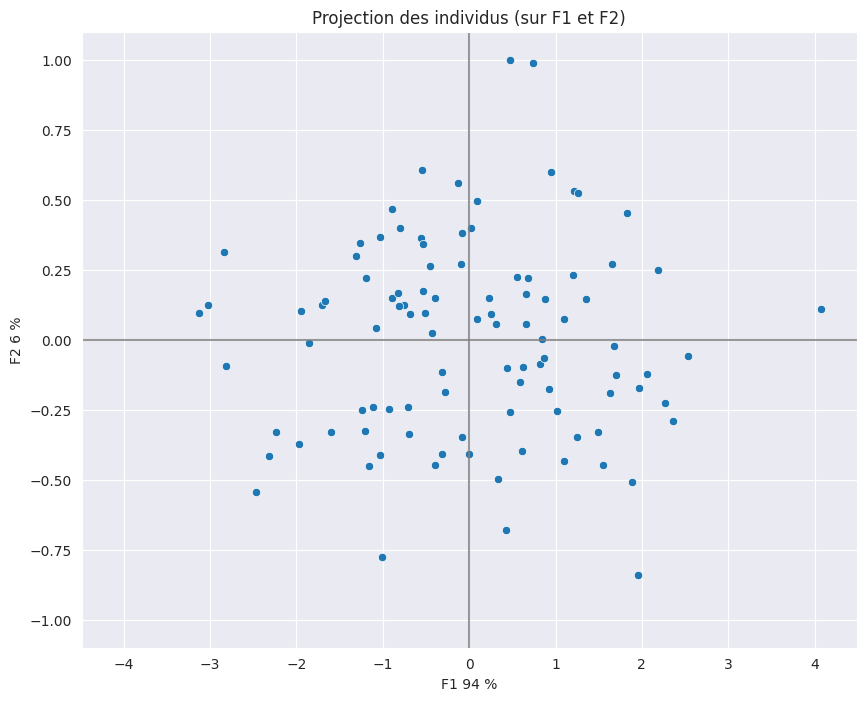

In [19]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, x_y, pca)

# Mise en place du K-means

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Méthode du coude pour choisir le nombre de clusters

In [21]:
inertia = []

In [22]:
k_list = list(range(1, 11))
k_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
for i in k_list:
    kmean = KMeans(n_clusters=i)
    kmean.fit(X_scaled)
    inertia.append(kmean.inertia_)

In [24]:
inertia

[199.99999999999997,
 75.08978717344912,
 47.87430725312193,
 30.38308987943084,
 25.248540227122827,
 22.45451653471972,
 17.94128264076916,
 17.445060306122627,
 15.145942135721874,
 11.920642527072403]

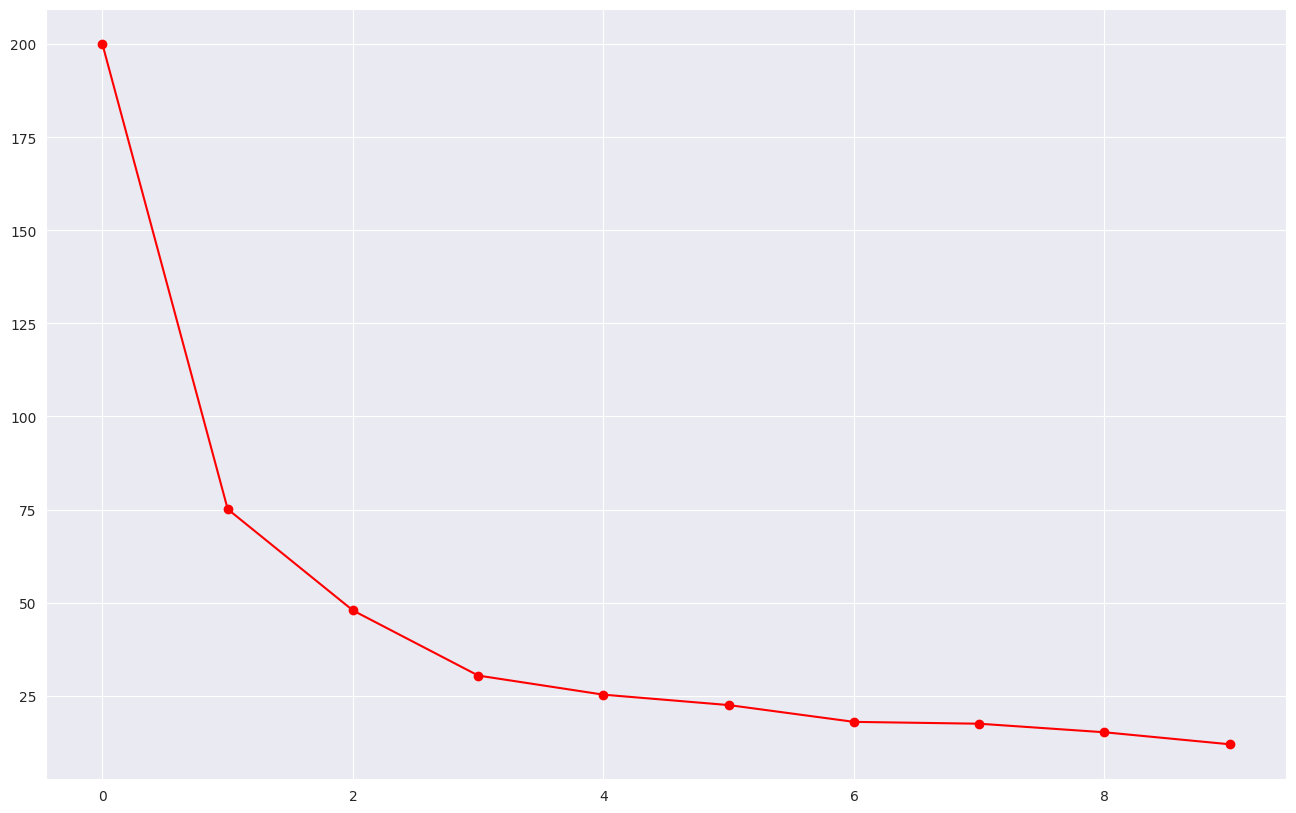

In [25]:
plt.figure(figsize=(16, 10))
plt.plot(inertia, marker="o", color="red")
plt.show()

On prendra donc 2 clusters

In [26]:
n_clusters = 2

In [27]:
kmean = KMeans(n_clusters=n_clusters)
kmean.fit(X_scaled)
labels = kmean.labels_

In [28]:
data['cluster'] = labels

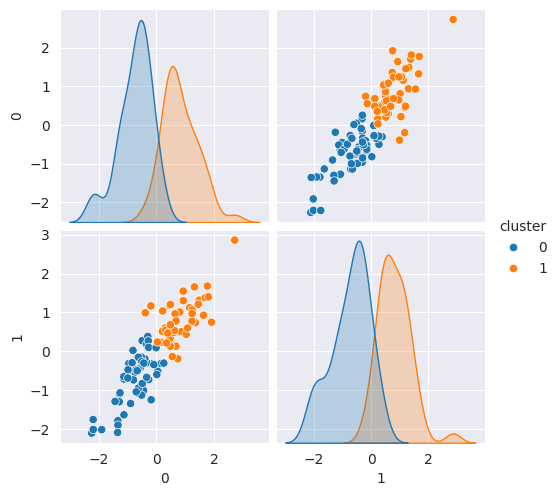

In [29]:
sns.pairplot(data=data, hue="cluster", palette="tab10")
plt.show()

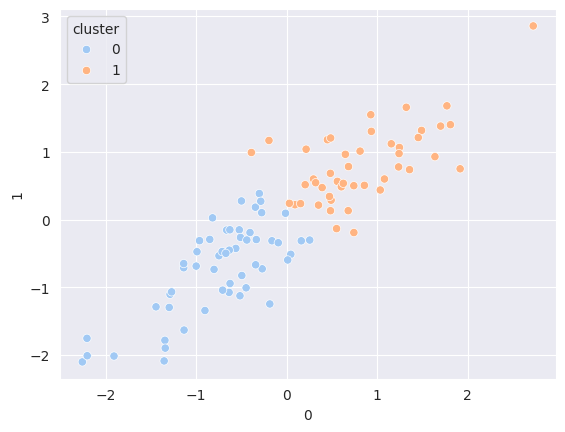

In [30]:
sns.scatterplot(data=data, x=0, y=1, hue="cluster", palette="pastel")
plt.show()

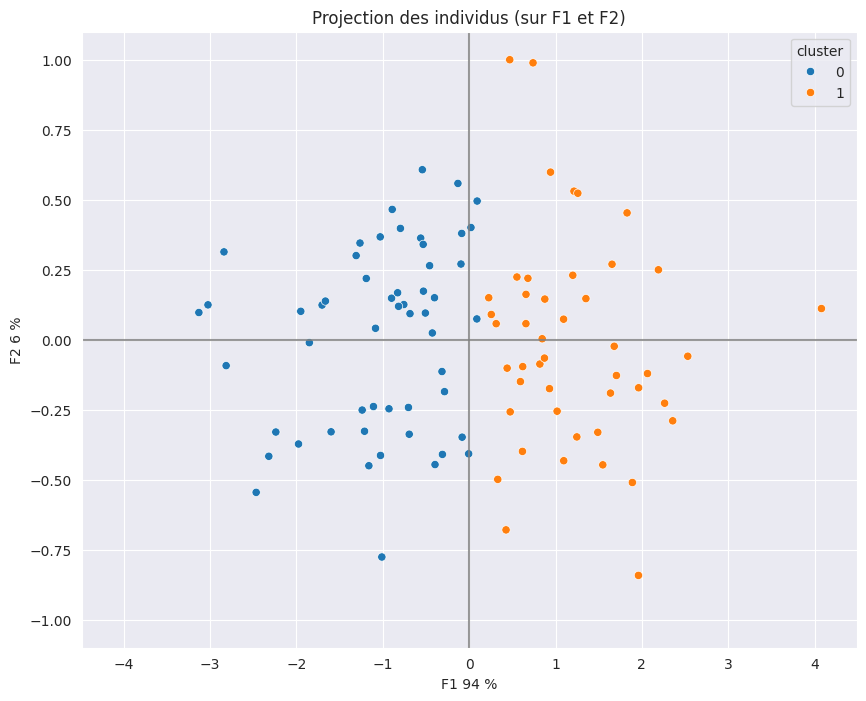

In [31]:
display_factorial_planes(X_projected, x_y, pca, clusters=data["cluster"])